# Tutorial 5 - FOSWEC
The goal of this tutorial is to show a design problem for a bottom-hinged oscillating-surge WEC.
The WEC in this tutorial is a single, fixed-bottom flap of the floating oscillating-surge WEC (FOSWEC).

* SAND report: https://doi.org/10.2172/1717884
* Journal paper: https://doi.org/10.1016/j.energy.2021.122485
* YouTube video: https://youtu.be/OUxbaEC2K6Y

This tutorial introduces...

In [7]:
import autograd.numpy as np
import capytaine as cpy
from capytaine.io.meshio import load_from_meshio
import matplotlib.pyplot as plt
from scipy.optimize import brute
import pygmsh
import gmsh
import xarray as xr
import ipympl

import wecopttool as wot

## set colorblind-friendly colormap for plots
plt.style.use('tableau-colorblind10')

%matplotlib inline

Text(0, 0.5, 'Torque (Nm)')

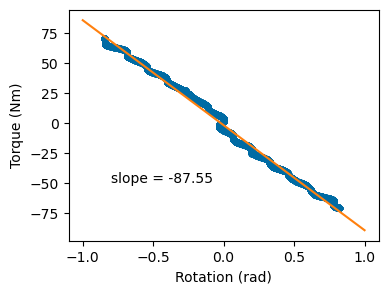

In [8]:
# load in data from ramps experiments
datafile = 'data/FOSWEC_ramps.nc'
ramps_data = xr.load_dataset(datafile)

# fit a linear curve
coefficients = np.polyfit(ramps_data['position'], ramps_data['torque'], 1)
pos_fitted = np.linspace(-1,1,100)
torque_fitted = np.polyval(coefficients, pos_fitted)

plt.figure(figsize=(4,3))
plt.plot(ramps_data['position'], ramps_data['torque'],'.')
plt.plot(pos_fitted,torque_fitted,'-')
plt.text(-0.8, -50, f'slope = {round(coefficients[0],2)}')
plt.xlabel('Rotation (rad)')
plt.ylabel('Torque (Nm)')

#plt.show()

## Single Flap Design Study
Because the hydrodynamics are so similar between both flaps of the FOSWEC (as evidenced by impedance plots above), we can simplify the design study to consider just one flap.
Results from the study should be applicable to both flaps. 


### Wave Conditions
Here, we define the wave conditions to select a proper frequency vector.
Because this study is only for regular waves, the fundamental frequency can be equal to the wave frequency and we only need about 12 frequencies total to capture all nonlinearities.

### Design Loop
The design loop here includes the tuned variables from above (draft and friction) as well as the center of gravity vertical location and rated generator power.
This enables a study which considers the impacts of changing the center of gravity of the flap (without altering the total mass) and using generators with different power ratings.

In [9]:
def one_flap_FOSWEC(draft, hs_coeff, z_cg_from_bottom, rotAngle):

    # parameters from experiments
    flap_height = 0.58 
    flap_draft = draft
    flap_freeboard = flap_height - flap_draft
    flap_width = 0.76
    flap_thickness_bottom = 0.05
    flap_thickness_top = 0.12
    hinge_location = -flap_draft - .046
    mass = 23.1
    pitch_inertia_about_cg = 1.19
    z_cg_from_bottom = z_cg_from_bottom
    z_cg = -flap_draft + z_cg_from_bottom

    mesh_size_factor = 0.2 # appropriate mesh size to avoid frequency spikes

    # mesh 1st flap
    with pygmsh.geo.Geometry() as geom:
        gmsh.option.setNumber('Mesh.MeshSizeFactor', mesh_size_factor)
        flap_poly = geom.add_polygon(
                [[-flap_thickness_bottom/2, -flap_width/2, -flap_draft],
                [flap_thickness_bottom/2, -flap_width/2, -flap_draft],
                [flap_thickness_top/2, -flap_width/2, flap_freeboard],
                [-flap_thickness_top/2, -flap_width/2, flap_freeboard]],mesh_size=mesh_size_factor)
        geom.rotate(flap_poly, [0,0,hinge_location], rotAngle, [0,1,0])
        geom.extrude(flap_poly,[0,flap_width,0])
        flap_mesh = geom.generate_mesh()

    # add degrees of freedom for rotation around bottom hinge
    flap_fb = cpy.FloatingBody(flap_mesh, name='flap_bow', center_of_mass=(0, 0, z_cg))
    axis = cpy.Axis(vector=(0, 1, 0), point=(0, 0, hinge_location))
    flap_fb.add_rotation_dof(name="pitch_about_hinge", axis=axis) # used for BEM
    flap_fb.rotation_center = (0, 0, hinge_location) # rotation center hydrostatics if not defined manually
    flap_fb.keep_immersed_part()

    # use parallel axis theorem to move inertia to base
    pitch_inertia_about_base = pitch_inertia_about_cg + mass*(z_cg - hinge_location)
    rigid_inertia_matrix_xr = xr.DataArray(data=pitch_inertia_about_base,
                                dims=['influenced_dof', 'radiating_dof'],
                                coords={'influenced_dof': list(flap_fb.dofs),
                                        'radiating_dof': list(flap_fb.dofs)},
                                name="inertia_matrix")
    flap_fb.inertia_matrix = rigid_inertia_matrix_xr

    stiffness_matrix_xr = xr.DataArray(data=hs_coeff,
                                dims=['influenced_dof', 'radiating_dof'],
                                coords={'influenced_dof': list(flap_fb.dofs),
                                        'radiating_dof': list(flap_fb.dofs)},
                                name="hydrostatic_stiffness")
    flap_fb.hydrostatic_stiffness = stiffness_matrix_xr

    return flap_fb

In [10]:
flap_fb = one_flap_FOSWEC(0.6, 0, 0.17, 0)

hs = flap_fb.compute_hydrostatics()
hs_capy = hs['hydrostatic_stiffness']
V = hs['disp_volume']
cb_z = hs['center_of_buoyancy'][2] - (-0.6 - 0.046) # distance from hinge to center of buoyancy
cg_z = 0.17 + 0.046 # including distance from hinge to bottom
#mass = 23.1
rho = 1000
g = 9.81

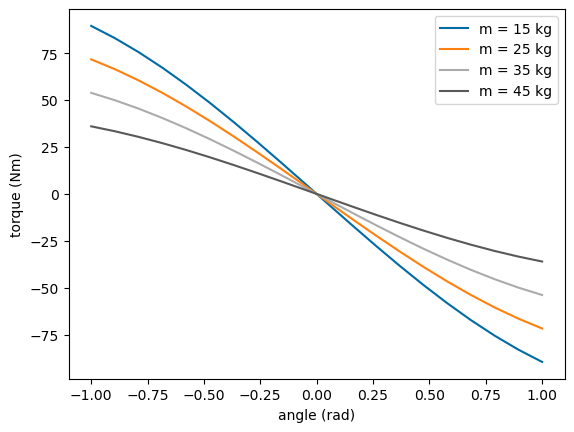

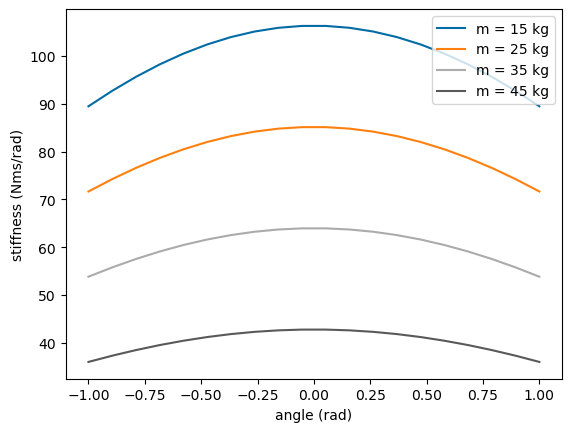

In [11]:
# Calculate hydrostatic stiffness analytically for different angles (all fully submerged) and mass values
angle_vec = np.linspace(-1,1,20)
mass_vec = np.linspace(15,45,4)

hs_torque_vec = np.zeros((len(angle_vec),len(mass_vec)))
hs_stiffness_vec = np.zeros((len(angle_vec),len(mass_vec)))

for angleInd, angle in enumerate(angle_vec):
    for massInd, mass in enumerate(mass_vec):
        hs_torque = -rho*V*g*cb_z*np.sin(angle) + mass*g*cg_z*np.sin(angle)
        hs_torque_vec[angleInd][massInd] = hs_torque
        hs_stiffness_vec[angleInd][massInd] = -hs_torque/angle

plt.figure()
for massInd, mass in enumerate(mass_vec):
    plt.plot(angle_vec,hs_torque_vec[:,massInd],label=f'm = {round(mass)} kg')

plt.xlabel('angle (rad)')
plt.ylabel('torque (Nm)')
plt.legend()

plt.figure()
for massInd, mass in enumerate(mass_vec):
    plt.plot(angle_vec,hs_stiffness_vec[:,massInd],label=f'm = {round(mass)} kg')

plt.xlabel('angle (rad)')
plt.ylabel('stiffness (Nms/rad)')
plt.legend()

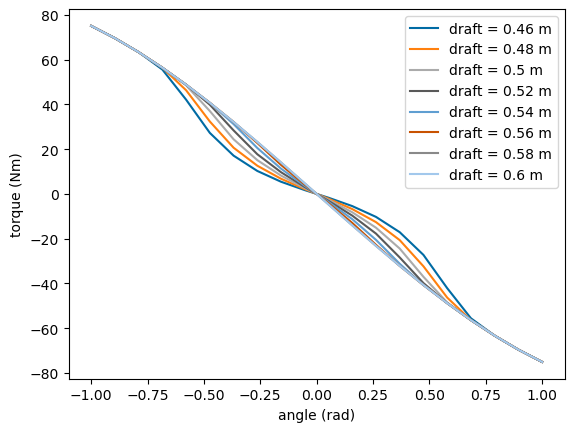

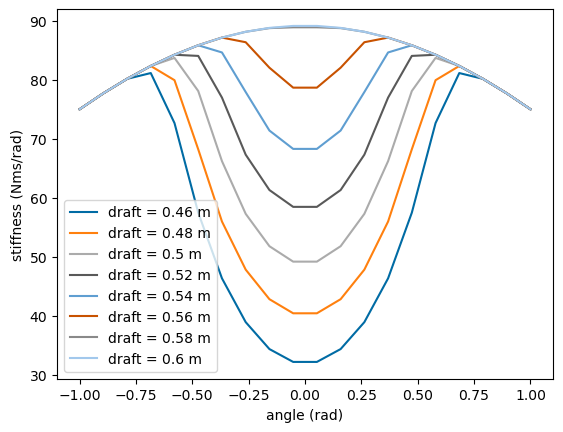

In [17]:
# Calculate hydrostatic stiffness analytically for different angles (all fully submerged) and mass values
angle_vec = np.linspace(-1,1,20)
draft_vec = np.linspace(0.46,0.6,8)

mass = 23.1

hs_torque_vec = np.zeros((len(angle_vec),len(draft_vec)))
hs_stiffness_vec = np.zeros((len(angle_vec),len(draft_vec)))
capy_hs = np.zeros((len(angle_vec),len(draft_vec)))

for angleInd, angle in enumerate(angle_vec):
    for draftInd, draft in enumerate(draft_vec):
        flap_fb = one_flap_FOSWEC(draft, 0, 0.17, angle)
        hinge_location = [0, 0, -draft - 0.046]

        hs = flap_fb.compute_hydrostatics()

        V = hs['disp_volume']
        capy_hs[angleInd][draftInd] = hs['hydrostatic_stiffness']
        cb_z = np.sqrt((hs['center_of_buoyancy'][0] - hinge_location[0])**2 + (hs['center_of_buoyancy'][1] - hinge_location[1])**2 + (hs['center_of_buoyancy'][2] - hinge_location[2])**2) # distance from hinge to center of buoyancy
        cg_z = 0.17 + 0.046 # including distance from hinge to bottom
        #mass = 23.1
        rho = 1000
        g = 9.81
        hs_torque = -rho*V*g*cb_z*np.sin(angle) + mass*g*cg_z*np.sin(angle)
        hs_torque_vec[angleInd][draftInd] = hs_torque
        hs_stiffness_vec[angleInd][draftInd] = -hs_torque/angle

plt.figure()
for draftInd, draft in enumerate(draft_vec):
    plt.plot(angle_vec,hs_torque_vec[:,draftInd],label=f'draft = {round(draft,2)} m')

plt.xlabel('angle (rad)')
plt.ylabel('torque (Nm)')
plt.legend()

plt.figure()
for draftInd, draft in enumerate(draft_vec):
    plt.plot(angle_vec,hs_stiffness_vec[:,draftInd],label=f'draft = {round(draft,2)} m')
    #plt.plot(angle_vec,capy_hs[:,draftInd],label=f'draft = {round(draft,2)} m')

plt.xlabel('angle (rad)')
plt.ylabel('stiffness (Nms/rad)')
plt.legend()